The code needs to be executed in the following order
1. Task1_clean.ipynb
2. Task1_eda.ipynb
3. Task1_clean_pt2.ipynb
4. Task1_backward_elimination.ipynb
5. **Task1_model.ipynb**

The EDA and Backward elimination has helped us find the optimal columns for regression training
Now we need to find out what results the machine learning algorithm will give.
A number of regresssion models are tested and the results compared.

Here we try XGBoost.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
import matplotlib.pyplot as plt
import xgboost as xg
from pathlib import Path
from openFile import OpenCleanFile

In [2]:
clean = OpenCleanFile()
clean.df_housing.head()
selected_columns = ['RESIDENTIAL UNITS', 'TOTAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 
'TAX CLASS AT PRESENT', 'TAX CLASS AT TIME OF SALE', 'BOROUGH_NAME']  
X, y = clean.df_housing[selected_columns], clean.df_housing["SALE PRICE"]
X.head()  


,RESIDENTIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,TAX CLASS AT PRESENT,TAX CLASS AT TIME OF SALE,BOROUGH_NAME
0,5,5,1633,6440,2A,2,Manhattan
1,10,10,2272,6794,2B,2,Manhattan
2,6,6,2369,4615,2A,2,Manhattan
3,8,8,1750,4226,2B,2,Manhattan
4,24,24,4489,18523,2,2,Manhattan


Turn the category columns into one-hot encoded columns per category and then select from those columns
the ones that were calculated from the backward elimination process

In [3]:
X = pd.get_dummies(X, drop_first=True)
selected_columns_all = [
    'RESIDENTIAL UNITS', 'TOTAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 
    'TAX CLASS AT PRESENT_2', 'TAX CLASS AT PRESENT_2A', 'TAX CLASS AT PRESENT_2B', 
    'TAX CLASS AT TIME OF SALE_2', 'TAX CLASS AT TIME OF SALE_4', 
    'BOROUGH_NAME_Brooklyn', 'BOROUGH_NAME_Manhattan', 'BOROUGH_NAME_Queens']

X = X[selected_columns_all]
X.head()

,RESIDENTIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,TAX CLASS AT PRESENT_2,TAX CLASS AT PRESENT_2A,TAX CLASS AT PRESENT_2B,TAX CLASS AT TIME OF SALE_2,TAX CLASS AT TIME OF SALE_4,BOROUGH_NAME_Brooklyn,BOROUGH_NAME_Manhattan,BOROUGH_NAME_Queens
0,5,5,1633,6440,0,1,0,1,0,0,1,0
1,10,10,2272,6794,0,0,1,1,0,0,1,0
2,6,6,2369,4615,0,1,0,1,0,0,1,0
3,8,8,1750,4226,0,0,1,1,0,0,1,0
4,24,24,4489,18523,1,0,0,1,0,0,1,0


This function RMSE_Computation is a helper function.

In [4]:
def RMSE_Computation(test_y, pred):
    # RMSE Computation
    rmse = np.sqrt(MSE(test_y, pred))
    print("RMSE : % f" %(rmse))

Now run the XGBoost model

In [5]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state = 42)
# create an xgboost regression model
model = xg.XGBRegressor()
# Instantiation
xgb_r = xg.XGBRegressor(objective ='reg:squarederror', n_estimators = 1000, seed = 42)
 
# Fitting the model
xgb_r.fit(train_X, train_y)
 
# Predict the model
pred = xgb_r.predict(test_X)
RMSE_Computation(test_y, pred)

RMSE :  12387351.181360


RMSE :  12338609.059416


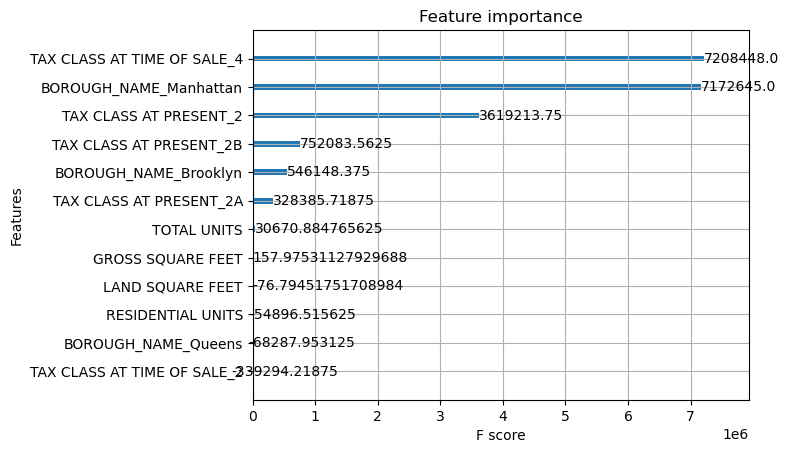

In [6]:
# Train and test set are converted to DMatrix objects,
# as it is required by learning API.
train_dmatrix = xg.DMatrix(data = train_X, label = train_y)
test_dmatrix = xg.DMatrix(data = test_X, label = test_y)
 
# Parameter dictionary specifying base learner
param = {"booster":"gblinear", "objective":"reg:squarederror"}
xgb_r = xg.train(params = param, dtrain = train_dmatrix, num_boost_round = 10)
xg.plot_importance(xgb_r, ax=plt.gca())
pred = xgb_r.predict(test_dmatrix)
RMSE_Computation(test_y, pred)

These results for XGBoost are very poor

Next, random forests

In [7]:
from sklearn.ensemble import RandomForestRegressor

In [8]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state = 42)
regr = RandomForestRegressor(max_depth=2, random_state=42)

regr.fit(train_X, train_y)
pred = regr.predict(test_X)
RMSE_Computation(test_y, pred)

RMSE :  12096464.376761


An RMSE of 12million is very poor. Curiously this is a slight improvement over XGBoost

Now try SVR

In [9]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [10]:
regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
regr.fit(train_X, train_y)
pred = regr.predict(test_X)
RMSE_Computation(test_y, pred)

RMSE :  15952689.969350


An RMSE of 16million is the worst one so far.

Lets try decision trees

In [11]:
from sklearn.tree import DecisionTreeRegressor

In [12]:
# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_1.fit(train_X, train_y)
pred = regr_1.predict(test_X)
print("Decision Tree Regression for max depth=2")
RMSE_Computation(test_y, pred)

regr_2 = DecisionTreeRegressor(max_depth=5)
regr_2.fit(train_X, train_y)
pred = regr_2.predict(test_X)
print("Decision Tree Regression for max depth=5")
RMSE_Computation(test_y, pred)

Decision Tree Regression for max depth=2
RMSE :  11992887.742863
Decision Tree Regression for max depth=5
RMSE :  13141543.538796


Decision Tree regression with a max depth of 2 has given the best results so far, but still very poor with an RMSE of just under 12million

Now try Ridge regression

In [13]:
from sklearn.linear_model import Ridge

In [14]:
clf = Ridge(alpha=1.0)
clf.fit(train_X, train_y)
pred = clf.predict(test_X)
RMSE_Computation(test_y, pred)

RMSE :  14279726.233523


Poor results for Ridge at 14million

Now try Lasso

In [15]:
from sklearn import linear_model

In [16]:
clf = linear_model.Lasso(alpha=0.1, max_iter=100000)
clf.fit(train_X, train_y)
pred = clf.predict(test_X)
RMSE_Computation(test_y, pred)

RMSE :  14281960.060552


Very similar results to Ridge

The best results come from the decision tree model. This is unexpected as normally the later models such as random forests and XGBoost would be expected to give better results. However the values for RMSE are poor and it is hard to read anything into these results.

** This is the end of the code to be run **